<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/pytorch/Chap_6_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoders

입력이 최대한 출력과 유사해지도록 하는 비지도학습 기술


application:
- 데이터 노이즈 제거
- 데이터 시각화를 위한 차원 축소
- 이미지 생성
- 텍스트 보간(interpolating)

<br>
<b>Bottlenect</b>: 입력에 대한 압축된 정보 표현

## 표준 오토인코더 Standard AutoEncoder

### 1. 라이브러리 가져오기

In [1]:
import os
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn
from torch.autograd import Variable
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.optim as optim

In [2]:
#for image
from matplotlib.pyplot import imshow
from PIL import Image
from IPython.display import Image 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
count = 0
import cv2
import shutil
import os
import numpy as np

### 2. 모델 파라미터 정의

In [ ]:
number_epochs = 11
batch_size = 128
learning_rate = 1e-4

In [ ]:
learning_rate >0

True

### 3. MNIST 데이터셋의 이미지들을 변형하는 함수 생성

In [ ]:
transform_image = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
])

In [ ]:
dataset = MNIST('./data',transform = transform_image, download = True)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
sample_data = next(iter(data_loader))

### 4. 데이터를 공급하는 autoencoder 클래스를 정의하고 모델을 생성한다

In [ ]:
class autoencoder_model(nn.Module):
  def __init__(self):
    super(autoencoder_model, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(True),
        nn.Linear(128,64),
        nn.ReLU(True),
        nn.Linear(64,12),
        nn.ReLU(True),
        nn.Linear(12,3)
    )
    self.decoder = nn.Sequential(
        nn.Linear(3,12),
        nn.ReLU(True),
        nn.Linear(12,64),
        nn.ReLU(True),
        nn.Linear(64,128),
        nn.ReLU(True),
        nn.Linear(128,28*28),
        nn.Tanh()
    )
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
model = autoencoder_model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay = 1e-5)

### 5. 각 에포크 이후에 모델로부터 이미지를 출력하는 함수를 정의한다.

In [ ]:
def to_image(x):
  x = 0.5*(x+1)
  x = x.clamp(0,1)#torch.clamp() method clamps all the input elements into the range [ min, max ] and return a resulting tensor.
  x = x.view(x.size(0),1,28,28)
  return x

### 6. 이제, 각 에포크를 반복하며 모델을 실행하고 재구성된 이미지의 결과를 검토한다.

In [ ]:
!mkdir mlp_img

In [ ]:
#count number of images in JPEGImages
import os, os.path
path, dirs, files = next(os.walk("/content/mlp_img"))
file_count = len(files)
assert file_count == 0

In [ ]:
for epoch in range(number_epochs):
  for data in data_loader:
    image, i = data
    image = image.view(image.size(0),-1)
    image = Variable(image)

    #forward
    output = model(image)
    loss = criterion(output, image)

    #backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print("Epoch [{}/{}], Loss:{:.4f}".format(epoch+1, number_epochs, loss.data))
  if epoch % 5 == 0:
    print("image saved at epoch {}".format(epoch))
    pic = to_image(output.cpu().data)
    save_image(pic, './mlp_img/image_{}.png'.format(epoch))
torch.save(model.state_dict(), './sim_autoencoder.pth')

Epoch [1/11], Loss:0.2611
image saved at epoch 0
Epoch [2/11], Loss:0.2441
Epoch [3/11], Loss:0.2091
Epoch [4/11], Loss:0.2106
Epoch [5/11], Loss:0.2070
Epoch [6/11], Loss:0.1982
image saved at epoch 5
Epoch [7/11], Loss:0.2070
Epoch [8/11], Loss:0.1952
Epoch [9/11], Loss:0.1742
Epoch [10/11], Loss:0.1936
Epoch [11/11], Loss:0.1877
image saved at epoch 10


view all processed images

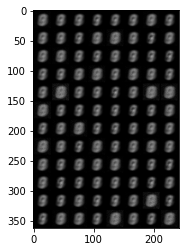

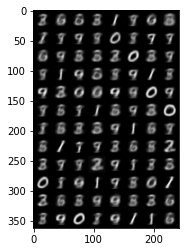

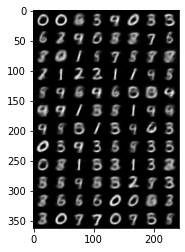

In [ ]:
%matplotlib inline
source = "/content/mlp_img"
files = os.listdir(source)

for file in files:
  file_name = os.path.join(source, file)
  img = mpimg.imread(file_name)
  plt.imshow(img, cmap = plt.get_cmap('gray')) 
  plt.show()#show the converted images

더 많은 에포크를 거치면, 모델이 계속 학습되기 때문에 이미지가 더 선명해진다.

## 합성곱 오토인코더 Convolutional Autoencoder

1D 벡터 대신 3D 벡터를 사용

### 1. 데이터셋 생성 + 모델 파라미터 정의

In [ ]:
number_epochs = 11
batch_size = 128
learning_rate = 1e-4

transform_image = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
])

dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform_image, download=True)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



#### 2. 모델 생성

In [ ]:
class conv_autoencoder(nn.Module):
  def __init__(self):
    super(conv_autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1,16,3,stride = 3,padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride = 2),
        nn.Conv2d(16,8,3,stride = 2, padding = 1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride = 1)
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(8,16,3,stride = 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(16,8,5,stride = 3, padding = 1),
        nn.ReLU(True),
        nn.ConvTranspose2d(8,1,2,stride = 2, padding =1),
        nn.Tanh()
    )
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

    
model = conv_autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)


#### 3. 훈련

In [ ]:
!mkdir dc_img

mkdir: cannot create directory ‘dc_img’: File exists


In [ ]:
len(data_loader)

469

In [ ]:
trace_loss = []
for epoch in range(number_epochs):
  train_loss = 0
  for idx,data in enumerate(data_loader):
    img, i = data
    img = Variable(img)
    #Forward pass
    output = model(img)
    loss = criterion(output, img)

    #backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.data
    if idx %100 == 0:
      print("idx: {} | epoch [{}/{}], loss: {:.4f}".format(idx,epoch+1, number_epochs, loss.data))
  trace_loss.append(train_loss / len(data_loader.dataset))
  print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_loader.dataset)))
  if epoch % 5 ==  0:
    print("image saved at epoch {}".format(epoch))
    pic = to_image(output.cpu().data)
    save_image(pic, './dc_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './convolutional_autoencoder.pth')

idx: 0 | epoch [1/11], loss: 1.5116
idx: 100 | epoch [1/11], loss: 1.4308
idx: 200 | epoch [1/11], loss: 1.0515
idx: 300 | epoch [1/11], loss: 0.6218
idx: 400 | epoch [1/11], loss: 0.5078
Epoch: 0 Average loss: 0.0074
image saved at epoch 0
idx: 0 | epoch [2/11], loss: 0.4805
idx: 100 | epoch [2/11], loss: 0.4279
idx: 200 | epoch [2/11], loss: 0.4374
idx: 300 | epoch [2/11], loss: 0.4031
idx: 400 | epoch [2/11], loss: 0.4139
Epoch: 1 Average loss: 0.0033
idx: 0 | epoch [3/11], loss: 0.4422
idx: 100 | epoch [3/11], loss: 0.4036
idx: 200 | epoch [3/11], loss: 0.4101
idx: 300 | epoch [3/11], loss: 0.4177
idx: 400 | epoch [3/11], loss: 0.4175
Epoch: 2 Average loss: 0.0032
idx: 0 | epoch [4/11], loss: 0.4227
idx: 100 | epoch [4/11], loss: 0.3997
idx: 200 | epoch [4/11], loss: 0.3846
idx: 300 | epoch [4/11], loss: 0.4230
idx: 400 | epoch [4/11], loss: 0.3913
Epoch: 3 Average loss: 0.0032
idx: 0 | epoch [5/11], loss: 0.4344
idx: 100 | epoch [5/11], loss: 0.4174
idx: 200 | epoch [5/11], loss: 

손실 그래프

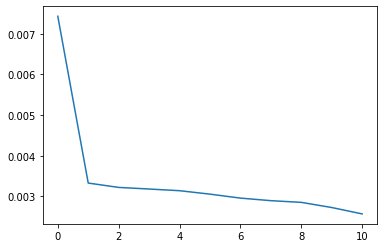

In [ ]:
plt.plot(trace_loss)
plt.show()

결과 이미지 보기

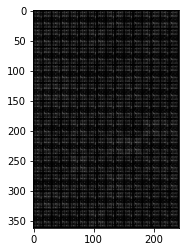

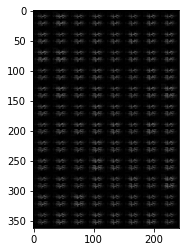

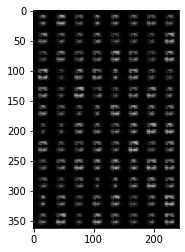

In [ ]:
%matplotlib inline
source = "/content/dc_img"
files = os.listdir(source)

for file in files:
  file_name = os.path.join(source, file)
  try:
    img = mpimg.imread(file_name)
  except:
    continue
  plt.imshow(img) 
  plt.show()#show the converted images

standard autoencoder보다 convolutional autoencoder 성능이 더 안 좋음

## 노이즈 제거(Denoising) 오토인코더

네트워크의 입력에 의도적으로 노이즈를 추가

**원본 입력에 노이즈를 추가하면 인코더가 그 입력을 인코더 해서 디코더로 보냄 -> 디코더는 노이즈가 추가된 입력을 깨끗한 출력이 되도록 디코딩**

# Variational Autoencoders

결정론적이 아닌 확률적인 방법으로 잠재적 공간에 있는 관측을 설명

- 표준 오토인코더: 입력된 데이터를 복제할 때만 유용
- VAE: 생성 모델, 입력과 동일한 데이터의 출력을 원하지 않는 경우에 적용 가능

Reparameterization 기법:
단일 정규 분포에서 ɛ를 샘플링해서 잠재된 속성의 평균 μ만큼 이동한 다음, 잠재된 속성의 분산 σ로 스케일링 해주는 것이다.

𝒵 = μ + σɛ

## 모델 구현

In [ ]:
import torch.nn.functional as F
class VariationalAutoEncoder(nn.Module):
  def __init__(self):
    super(VariationalAutoEncoder, self).__init__()
    self.fc1 = nn.Linear(784,400)
    self.fc21 = nn.Linear(400,20)
    self.fc22 = nn.Linear(400,20)
    self.fc3 = nn.Linear(20,400)
    self.fc4 = nn.Linear(400,784)

  def encode_function(self, x):
    h1 = F.relu(self.fc1(x))
    return self.fc21(h1), self.fc22(h1)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    if torch.cuda.is_available():
      eps = torch.cuda.FloatTensor(std.size()).normal_()
    else:
      eps = torch.FloatTensor(std.size()).normal_()
    eps = Variable(eps)#A PyTorch Variable is a wrapper around a PyTorch Tensor, and represents a node in a computational graph. 
    return eps.mul(std).add_(mu)
  
  def decode_function(self,z):
    h3 = F.relu(self.fc3(z))
    return F.sigmoid(self.fc4(h3))
  
  def forward(self,x):
    mu, logvar = self.encode_function(x)
    z = self.reparametrize(mu, logvar)
    return self.decode_function(z),mu,logvar
  


In [ ]:
model = VariationalAutoEncoder()
if torch.cuda.is_available():
  model.cuda()

In [ ]:
reconstruction_function = nn.MSELoss(size_average=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def loss_function(reconstruction_x, x, mu, latent_log_variance):
  """
  reconstruction_x:generating images,
  x: original images
  mu: latent mean
  """
  BCE=reconstruction_function(reconstruction_x,x)
  # KL loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD_aspect = mu.pow(2).add_(latent_log_variance.exp()).mul_(-1).add_(1).add_(logvar)
  KLD = torch.sum(KLD_aspect).mul_(-0.5)
  # KL divergence
  return BCE + KLD

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## 하이퍼파라미터 및 기타 함수 구현

In [ ]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

number_epochs = 10
batch_size = 128
learning_rate = 1e-4

transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=transform_image,download = True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

def to_image(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## 훈련

In [ ]:
!mkdir vae_img

mkdir: cannot create directory ‘vae_img’: File exists


In [ ]:
number_epochs = 11

In [ ]:
trace_loss2 = []
for epoch in range(number_epochs):
  model.train()#tells your model that you are training the model. 
  #So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.
  train_loss = 0
  for batch_idx, data in enumerate(data_loader):
    img, _ = data
    img = img.view(img.size(0),-1)
    img = Variable(img)
    if torch.cuda.is_available():
      img = img.cuda()
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(img)
    loss = loss_function(recon_batch, img, mu, logvar)
    loss.backward()
    train_loss += loss.data
    optimizer.step()
    if batch_idx %100 == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}".format(epoch, batch_idx*len(img),len(data_loader.dataset), 100.*batch_idx/len(data_loader), loss.data/len(img)))
  print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(data_loader.dataset)))
  trace_loss2.append(train_loss / len(data_loader.dataset))
  if epoch % 10 == 0:
    save = to_image(recon_batch.cpu().data)
    save_image(save, "./vae_img/img_{}.png".format(epoch))

torch.save(model.state_dict(), './vae.pth')      


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	 Loss: 1491.677124
Train Epoch: 0 [12800/60000 (21%)]	 Loss: 836.623047
Train Epoch: 0 [25600/60000 (43%)]	 Loss: 779.864014
Train Epoch: 0 [38400/60000 (64%)]	 Loss: 757.684937
Train Epoch: 0 [51200/60000 (85%)]	 Loss: 750.611084
Epoch: 0 Average loss: 832.9587
Train Epoch: 1 [0/60000 (0%)]	 Loss: 746.405151
Train Epoch: 1 [12800/60000 (21%)]	 Loss: 740.540283
Train Epoch: 1 [25600/60000 (43%)]	 Loss: 737.761902
Train Epoch: 1 [38400/60000 (64%)]	 Loss: 735.909180
Train Epoch: 1 [51200/60000 (85%)]	 Loss: 732.444397
Epoch: 1 Average loss: 738.4053
Train Epoch: 2 [0/60000 (0%)]	 Loss: 734.385071
Train Epoch: 2 [12800/60000 (21%)]	 Loss: 735.126648
Train Epoch: 2 [25600/60000 (43%)]	 Loss: 732.381104
Train Epoch: 2 [38400/60000 (64%)]	 Loss: 730.489624
Train Epoch: 2 [51200/60000 (85%)]	 Loss: 731.011414
Epoch: 2 Average loss: 732.7872
Train Epoch: 3 [0/60000 (0%)]	 Loss: 732.102234
Train Epoch: 3 [12800/60000 (21%)]	 Loss: 731.388062
Train Epoch: 3 [25600/

손실 그래프

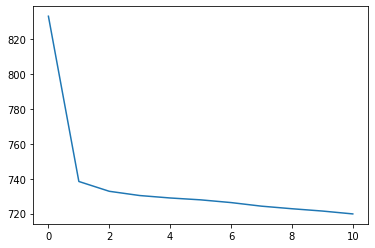

In [ ]:
plt.plot(trace_loss2)
plt.show()

show image

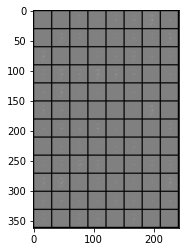

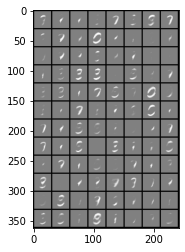

In [ ]:
source = "/content/vae_img"
files = os.listdir(source)
for file in files:
    file_name = os.path.join(source, file)
    try:
      img = mpimg.imread(file_name)
    except:
      continue
    plt.imshow(img) 
    plt.show()

## Output이 이상하기 때문에 다시 함

참고: https://towardsdatascience.com/beginner-guide-to-variational-autoencoders-vae-with-pytorch-lightning-13dbc559ba4b

<b>Reparametrization Trick</b>

utilize the reparametrization trick which allows us to separate the stochastic and deterministic parts of the operation. How this works is that we sample from a standard normal distribution N(0,I) and use the μ and σ vector to transform it.


In [ ]:
def to_image(x):
  x = 0.5*(x+1)
  x = x.clamp(0,1)#torch.clamp() method clamps all the input elements into the range [ min, max ] and return a resulting tensor.
  x = x.view(x.size(0),1,28,28)
  return x

In [ ]:
batch_size = 32

In [ ]:
#dataset부터 다시 준비
transform_image = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,))
])

train_set = MNIST('data/',download = True,train = True,transform=transform_image)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
sample = next(iter(train_loader))

In [ ]:
len(sample)

2

In [ ]:
len(sample[0])

32

In [ ]:
save_image(to_image(sample[0].cpu().data),"original.png")

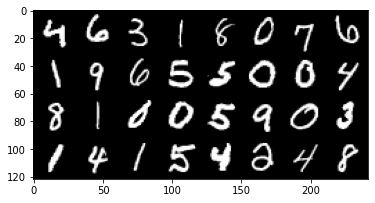

<Figure size 720x936 with 0 Axes>

In [ ]:
img = mpimg.imread("/content/original.png")
plt.imshow(img) 
plt.figure(figsize=(10,13))
plt.show()

In [ ]:
class VAE(nn.Module):
  def __init__(self, alpha = 1):
    super().__init__()
    self.encoder = nn.Sequential(nn.Linear(784, 196),
                                 nn.ReLU(),
                                 #nn.BatchNorm1d(196, momentum = 0.7),
                                 nn.Linear(196,49),
                                 nn.ReLU(),
                                 #nn.BatchNorm1d(49,momentum = 0.7),
                                 nn.Linear(49,28),
                                 nn.ReLU()
                                 )
    #convert the bottleneck into the μ and σ vectors. 
    self.hidden2mu = nn.Linear(28,28)
    self.hidden2log_var = nn.Linear(28,28)
    self.alpha = alpha
    self.decoder = nn.Sequential(nn.Linear(28,49),
                                 nn.ReLU(),
                                 nn.Linear(49,196),
                                 nn.ReLU(),
                                 nn.Linear(196,784),
                                 nn.ReLU())
  
  def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self.hidden2mu(h_enc)
        log_sigma = self.hidden2log_var(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick
  
  def forward(self,x):
       h_enc = self.encoder(x)
       z = self._sample_latent(h_enc)
       return self.decoder(z)
    

In [ ]:
model = VAE()
#model.cuda()

In [ ]:
!mkdir new_vae2

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.1)

In [ ]:
number_epochs = 11
input_dim = 28*28

In [ ]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [ ]:
trace_loss3 = []
recon_loss_criterion = nn.MSELoss()
for epoch in range(number_epochs):
  model.train()#tells your model that you are training the model. 
  #So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.
  train_loss = 0
  

  for batch_idx, data in enumerate(train_loader):
    img, classes = data
    optimizer.zero_grad()
    img, classes = Variable(img.resize_(batch_size, input_dim)), Variable(classes)
    dec = model.forward(img)
    ll = latent_loss(model.z_mean, model.z_sigma)
    loss = recon_loss_criterion(dec, img)+ll
    loss.backward()
    train_loss += loss.data
    optimizer.step()
    if batch_idx %100 == 0:
      print("Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}".format(epoch, batch_idx*len(img),len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.data/len(img)))
  print('Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
  trace_loss3.append(train_loss / len(train_loader.dataset))
  if epoch % 5 == 0:
    save = to_image(dec.cpu().data)
    save_image(save, "./new_vae2/img_{}.png".format(epoch))

torch.save(model.state_dict(), './new_vae2.pth')      


Train Epoch: 0 [0/60000 (0%)]	 Loss: 0.031662
Train Epoch: 0 [3200/60000 (5%)]	 Loss: 0.031610
Train Epoch: 0 [6400/60000 (11%)]	 Loss: 0.031734
Train Epoch: 0 [9600/60000 (16%)]	 Loss: 0.031489
Train Epoch: 0 [12800/60000 (21%)]	 Loss: 0.031693
Train Epoch: 0 [16000/60000 (27%)]	 Loss: 0.031917
Train Epoch: 0 [19200/60000 (32%)]	 Loss: 0.031518
Train Epoch: 0 [22400/60000 (37%)]	 Loss: 0.031783
Train Epoch: 0 [25600/60000 (43%)]	 Loss: 0.031547
Train Epoch: 0 [28800/60000 (48%)]	 Loss: 0.031576
Train Epoch: 0 [32000/60000 (53%)]	 Loss: 0.031711
Train Epoch: 0 [35200/60000 (59%)]	 Loss: 0.031752
Train Epoch: 0 [38400/60000 (64%)]	 Loss: 0.031996
Train Epoch: 0 [41600/60000 (69%)]	 Loss: 0.031743
Train Epoch: 0 [44800/60000 (75%)]	 Loss: 0.031454
Train Epoch: 0 [48000/60000 (80%)]	 Loss: 0.031634
Train Epoch: 0 [51200/60000 (85%)]	 Loss: 0.031699
Train Epoch: 0 [54400/60000 (91%)]	 Loss: 0.031664
Train Epoch: 0 [57600/60000 (96%)]	 Loss: 0.031682
Epoch: 0 Average loss: 0.0317
Train Epoc

KeyboardInterrupt: ignored

손실 그래프

In [ ]:
plt.plot(trace_loss3)
plt.show()

view image

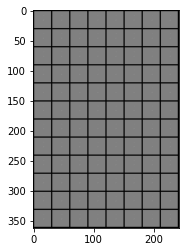

<Figure size 720x936 with 0 Axes>

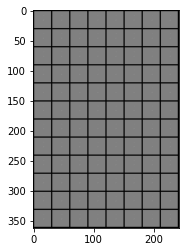

<Figure size 720x936 with 0 Axes>

In [ ]:
source = "/content/new_vae2"
files = os.listdir(source)
for file in files:
    file_name = os.path.join(source, file)
    try:
      img = mpimg.imread(file_name)
    except:
      continue
    plt.imshow(img) 
    plt.figure(figsize=(10,13))
    plt.show()

# Restricted Boltzmann Machines(제한된 볼츠만머신)
RBM은 협업 필터링, 특징 추출, 주제 모델링, 차원 감소와 같은 작업에 널리 사용되는 알고리즘이다. 비지도 학습 방식으로 데이터셋의 패턴을 학습할 수 있다.
(결정을 내린 이유를 생각하는데 도움)

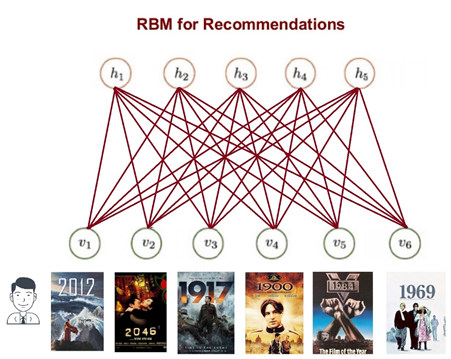

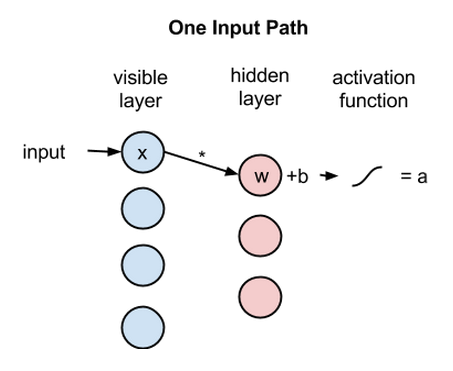

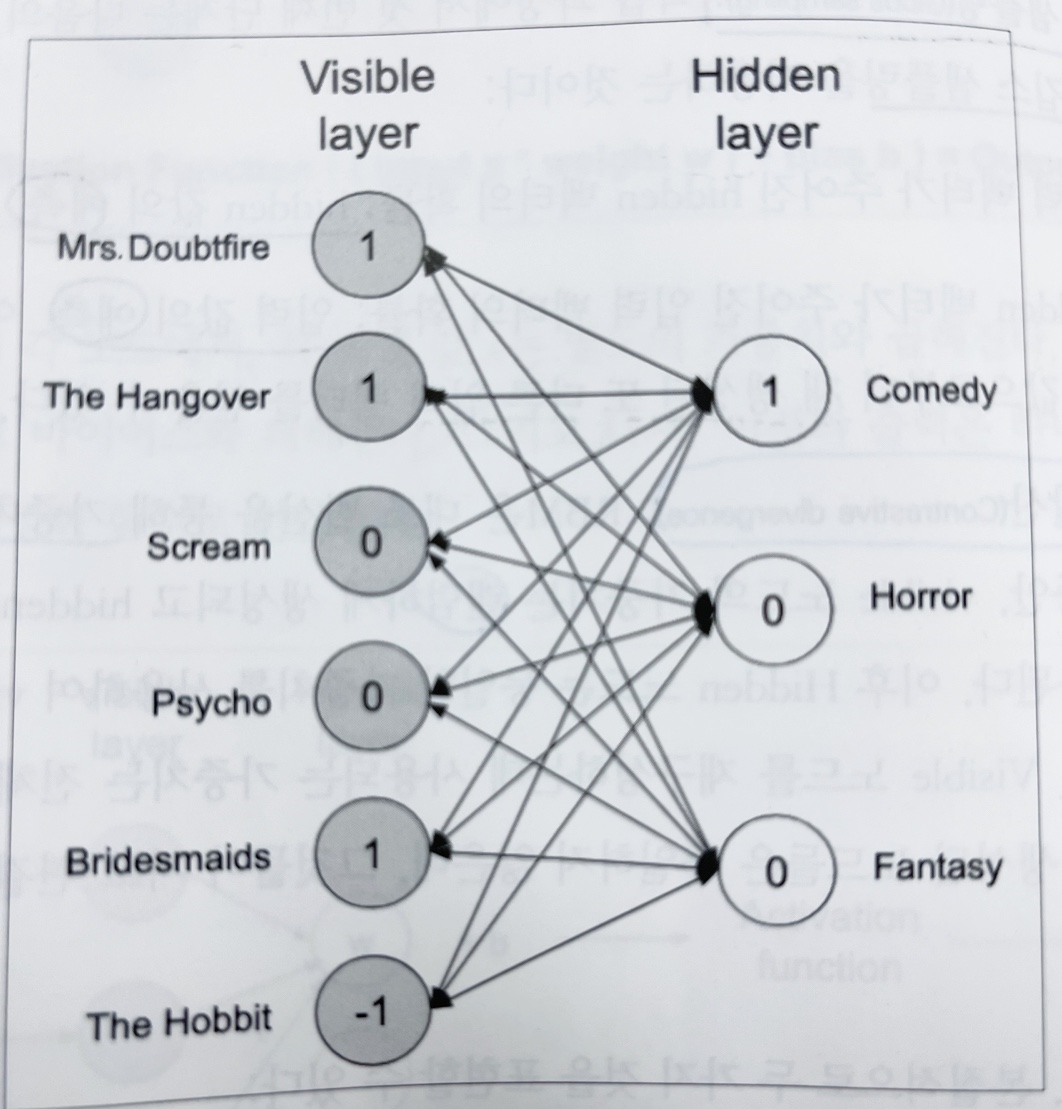

## RBM 학습하기
### 1. 깁스 샘플링(Gibbs Sampling):
과정(1),과정(2)를 k번 반복
- 입력 벡터가 주어진 hidden 벡터의 확률: hidden 값의 예측
- hidden 벡터가 주어진 입력 벡터의 확률: 입력 값의 예측

### 2. 대조 발산(Contrastive Divergence):
- 가중치 조정 과정


RBM이 학습되면, 본질적으로 두 가지 것을 표현할 수 있다.
- 입력 데이터의 특징들 간의 관계
- 패턴을 식별할 때 어떤 특징이 가장 중요한지

<br>
What makes Boltzmann machine models different from other deep learning models is that they’re undirected and don’t have an output layer. The other key difference is that all the hidden and visible nodes are all connected with each other. Due to this interconnection, Boltzmann machines can generate data on their own. As such, it can be classified as a generative deep learning model.

What makes RBMs different from Boltzmann machines is that visible nodes aren’t connected to each other, and hidden nodes aren’t connected with each other. Other than that, RBMs are exactly the same as Boltzmann machines.

Since RBMs are undirected, they don’t adjust their weights through gradient descent and backpropagation. They adjust their weights through a process called contrastive divergence. At the start of this process, weights for the visible nodes are randomly generated and used to generate the hidden nodes. These hidden nodes then use the same weights to reconstruct visible nodes. The weights used to reconstruct the visible nodes are the same throughout. However, the generated nodes are not the same because they aren’t connected to each other.

## RBM 추천 시스템: 사용자가 영화를 좋아할 것인지 또는 그렇지 않을지 판단

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

### 데이터셋 다운로드

In [5]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -o ml-latest-small.zip -d ./data
!unzip -o ml-latest-small.zip -d ./data

--2022-01-03 03:57:39--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   945KB/s    in 1.0s    

2022-01-03 03:57:41 (945 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ./data/ml-latest-small/
  inflating: ./data/ml-latest-small/links.csv  
  inflating: ./data/ml-latest-small/tags.csv  
  inflating: ./data/ml-latest-small/ratings.csv  
  inflating: ./data/ml-latest-small/README.txt  
  inflating: ./data/ml-latest-small/movies.csv  
Archive:  ml-latest-small.zip
  inflating: ./data/ml-latest-small/links.csv  
  inflating: ./data/ml-latest-small/tags.csv  
  inflating: ./data/ml-latest-small

### 라이브러리 임포트

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

### 데이터 임포트

In [16]:
movies = pd.read_csv('data/ml-latest-small/movies.csv', sep = ',', header = [0], engine = 'python')
users = pd.read_csv('data/ml-latest-small/links.csv', sep = ',', header = [0], engine = 'python')
ratings = pd.read_csv('data/ml-latest-small/ratings.csv', sep = ',', header = [0], engine = 'python')

데이터 보기

In [17]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
users.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [19]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### 테스트 및 학습을 위한 데이터셋

음 다시 가져옴 원래 사이트 들어가서..

In [23]:
#https://grouplens.org/datasets/movielens/1m/

In [24]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [25]:
movies = pd.read_csv('ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
users = pd.read_csv('ml-1m/users.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')
ratings = pd.read_csv('ml-1m/ratings.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1')

In [47]:
movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [48]:
users.head()

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [49]:
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [28]:
!unzip /content/ml-100k.zip

Archive:  /content/ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [32]:
training_set = pd.read_csv('ml-100k/u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('ml-100k/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int') 

In [34]:
training_set#User Id, movie ID, rating, timestamp

array([[        1,         2,         3, 876893171],
       [        1,         3,         4, 878542960],
       [        1,         4,         3, 876893119],
       ...,
       [      943,      1188,         3, 888640250],
       [      943,      1228,         3, 888640275],
       [      943,      1330,         3, 888692465]])

### Generate matrix for use in the RBM

In [33]:
no_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
no_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [35]:
def convert(data):
    new_data = []
    for id_users in range(1, no_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(no_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

convert our training and test data into a matrix.

In [36]:
training_set = convert(training_set)
test_set = convert(test_set)

In [37]:
#Convert the data into torch sensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

Convert the ratings into zeros and ones

In [38]:
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

### Creating the RBM Architecture

In [50]:
class RBM():
    def __init__(self, nv, nh):
      #nv: number of visible nodes
      #nh: number of hidden nodes
        self.W = torch.randn(nh, nv)#W: weight, normal distribution
        #1: batch size
        self.a = torch.randn(1, nh)#the probability of the hidden nodes given the visible nodes
        self.b = torch.randn(1, nv)#the probability of the visible nodes

    def sample_h(self, x):#sample the hidden nodes
    #x: visible neurons
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)#probability of hidden nodes given visible nodes
        return p_h_given_v, torch.bernoulli(p_h_given_v)#bernoulli samples of the hidden neurons

    def sample_v(self, y):#sample the visible nodes
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train(self, v0, vk, ph0, phk):
      #v0: the input vector containing the movie ratings
      #vk: the visible nodes obtained after k samplings
      #ph0: the vector of probabilities
      #phk: probabilities of the hidden nodes after k samplings.
        init = torch.mm(v0.t(), ph0)
        final = torch.mm(vk.t(), phk)
        self.W += (init-final).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

hyper parameters

In [51]:
#The number of visible nodes corresponds to the number of features in our training set.
nv = len(training_set[0])#number of visible nodes:  the length of the training set
nh = 200# number of hidden nodes: The number of hidden nodes determines the number of features that we’d like our RBM to detect.
batch_size = 100
rbm = RBM(nv, nh)
nb_epoch = 10#number of epochs

### Training the RBM

After each epoch, the weight will be adjusted in order to improve the predictions. Finally, we obtain the visible nodes with the ratings of the movies that were not rated by the users.


In [52]:
loss_list = []
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, no_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    loss_list.append(train_loss/s)
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(0.3462)
epoch: 2 loss: tensor(0.2527)
epoch: 3 loss: tensor(0.2431)
epoch: 4 loss: tensor(0.2493)
epoch: 5 loss: tensor(0.2475)
epoch: 6 loss: tensor(0.2456)
epoch: 7 loss: tensor(0.2497)
epoch: 8 loss: tensor(0.2430)
epoch: 9 loss: tensor(0.2477)
epoch: 10 loss: tensor(0.2438)


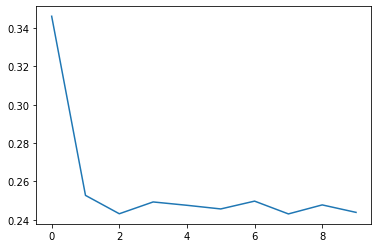

In [53]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

### Testing the RBM

In [46]:
test_loss = 0
s = 0.
for id_user in range(no_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.2562)
